# PHI Data Request

## 0. Setup

In [5]:
import climakitae as ck
from climakitae.core.data_interface import (
    get_data_options,
    get_subsetting_options,
    get_data,
)
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd

## 1. Parameters

- Downscaling: LOCA2

- Temporal scale: Annual

- Time periods: 1 value per 30 year spread

    - Past (1961-1990) -> LOCA2 DOES go back this, goes back to 1950

    - Current (2005-2034) -> May need to stitch together historical and future projections
    
    - Mid-century (1935-1964)

    - End-century (2070-2099) time periods

- Variable: Average (across models) count of days over with maximum temperature over <threshold> per year

    - 90°

    - 100°

- GCMs: All

- SSPs: 5.85

- Format: NetCDF or Geotiff

In [6]:
mode = 'test' # 'test' or 'full_run'

test_time_slices_dict = {
    "test1": (1995, 2000),
    "test2": (2005, 2010)
}

time_slices_dict = {
    "past": (1961, 1990),
    "current": (2005, 2034),
    "mid-century": (2035, 2064),
    "end-century": (2070, 2099),
}

if mode == 'test':
    area = "San Francisco County"
    dict_slices_run = test_time_slices_dict
elif mode == 'full_run':
    area = "CA"
    dict_slices_run = time_slices_dict


if mode == "test":
    area = "San Francisco County"
    dict_slices_run = test_time_slices_dict
elif mode == "full_run":
    area = "CA"
    dict_slices_run = time_slices_dict

# parameters
max_temp_params = {
    "variable": "Maximum air temperature at 2m",
    "resolution": "3 km",  # CHANGE ME
    "timescale": "daily",
    "downscaling_method": "Statistical",
    "scenario": ["Historical Climate", "SSP 5-8.5"],
    "units": "degF",
    # "time_slice": ()
    "cached_area": area,
}

min_temp_params = {
    "variable": "Minimum air temperature at 2m",
    "resolution": "3 km",  # CHANGE ME
    "timescale": "daily",
    "downscaling_method": "Statistical",
    "scenario": ["Historical Climate", "SSP 5-8.5"],
    "units": "degF",
    # "time_slice": ()
    "cached_area": area,
}

hist_max_temp_params = {
    "variable": "Maximum air temperature at 2m",
    "resolution": "3 km",  # CHANGE ME
    "timescale": "daily",
    "downscaling_method": "Statistical",
    "scenario": ["Historical Climate"],
    "units": "degF",
    # "time_slice": ()
    "cached_area": area,
}

hist_min_temp_params = {
    "variable": "Minimum air temperature at 2m",
    "resolution": "3 km",  # CHANGE ME
    "timescale": "daily",
    "downscaling_method": "Statistical",
    "scenario": ["Historical Climate"],
    "units": "degF",
    # "time_slice": ()
    "cached_area": area,
}

In [ ]:
get_data_options(downscaling_method="Statistical", resolution="3 km",timescale="daily",scenario= ["Historical Climate", "SSP 5-8.5"])

In [ ]:
get_subsetting_options(area_subset="CA counties")

## 2. Functions
- Average annual number of extreme heat days above 90 deg F
- Average annual number of extreme heat days above 100 deg F
- Average annual number of extreme heat days above historical baseline (98th percentile)
- Average annual number of warm nights (based on historical 98th percentile)


In [7]:
# extreme heat days above given temperature threshold

def count_days_above_X_degF(data, temp_threshold_in_degF):
    return (data.mean('simulation') > temp_threshold_in_degF).groupby('time.year').sum('time').squeeze()

def avg_days_above_X_degF(data, temp_threshold_in_degF):
    return (data.mean('simulation') > temp_threshold_in_degF).groupby('time.year').sum('time').mean('year').squeeze()

In [ ]:
# extreme heat days above historical baseline (98th percentile)
# from CRAI script: climate_ae_extreme_heat_metrics.py

def avg_days_above_percentile(hist_data, data, percentile):

    # select April through October over which to compute the 98th percentile
    months_to_measure = [m for m in np.arange(4, 11, 1)]

    # compute 98th percentile historical temperature between April and October
    hist_thresh = (
        hist_data.sel(time=hist_data.time.dt.month.isin(months_to_measure))
        .quantile(percentile, dim="time") # most computationally intense
    )
    
    # select out scenario to reduce complexity
    data = data.isel(scenario = 0)

    # count total days > 98th percentile in historical data and take average across time slice
    hist_count = (
        xr.where(data > hist_thresh, x=1, y=0)
        .groupby("time.year")
        .sum("time")
        .mean(dim="year")
        .mean(dim="simulation")
        .squeeze()
    )

    return hist_count

## 3. Testing

In [21]:
time_slices = [(1995, 2000),(2005, 2010)]

In [22]:
# general_params['time_slice'] = time_slices[1]

# test_data_0_min = get_data(**min_temp_params, time_slice=time_slices[0])
test_data_0_max = get_data(**max_temp_params, time_slice=time_slices[0])
# test_data_0_hist_min = get_data(**hist_min_temp_params, time_slice=time_slices[0])
# test_data_0_hist_max = get_data(**hist_max_temp_params, time_slice=time_slices[0])


# test_data_1_min = get_data(**min_temp_params, time_slice=time_slices[1])
test_data_1_max = get_data(**max_temp_params, time_slice=time_slices[1])
# test_data_1_hist_min = get_data(**hist_min_temp_params, time_slice=time_slices[1])
# test_data_1_hist_max = get_data(**hist_max_temp_params, time_slice=time_slices[1])

### Average annual number of extreme heat days above 90 deg F

In [ ]:
temp_threshold = 90

results = []

for label, time_slice in dict_slices_run.items():

    # retrieve data
    data = get_data(**max_temp_params, time_slice=time_slice)

    # for that time slice, calculate the average number of days above a temperature threshold in the time slice
    result = avg_days_above_X_degF(data, temp_threshold_in_degF=temp_threshold)
    print()

    # add time slice name as a dimension
    result = result.expand_dims({"time_slice_name": [label]})

    # now append this result to the ongoing list of results
    results.append(result)

# concatenate all along the new "time_slice_name" dimension
combined_90 = xr.concat(results, dim="time_slice_name")

# add in the time ranges to the dataset coordinates
combined_90 = combined_90.assign_coords(
    {
        "time_slice_range": (
            "time_slice_name",
            [f"{t[0]}–{t[1]}" for t in dict_slices_run.values()],
        )
    }
)

# rename
combined_90.name = f"avg annual # extreme heat days above {temp_threshold} F"

# export to local, as netCDF
combined_90.to_netcdf(
    path=f"avg_extreme_heat_days_over_{temp_threshold}.nc", engine="netcdf4"
)

### Average annual number of extreme heat days above 100 deg F

In [ ]:
temp_threshold = 100

results = []

for label, time_slice in dict_slices_run.items():

    # retrieve data
    data = get_data(**max_temp_params, time_slice=time_slice)

    # for that time slice, calculate the average number of days above a temperature threshold in the time slice
    result = avg_days_above_X_degF(data, temp_threshold_in_degF=temp_threshold)
    print()

    # add time slice name as a dimension
    result = result.expand_dims({"time_slice_name": [label]})

    # now append this result to the ongoing list of results
    results.append(result)

# concatenate all along the new "time_slice_name" dimension
combined_100 = xr.concat(results, dim="time_slice_name")

# add in the time ranges to the dataset coordinates
combined_100 = combined_100.assign_coords(
    {
        "time_slice_range": (
            "time_slice_name",
            [f"{t[0]}–{t[1]}" for t in dict_slices_run.values()],
        )
    }
)

# rename
combined_100.name = f"avg annual # extreme heat days above {temp_threshold} F"

# export to local, as netCDF
combined_100.to_netcdf(path=f"avg_extreme_heat_days_over_{temp_threshold}.nc", engine="netcdf4")

### Average annual number of extreme heat days above historical baseline (98th percentile)

In [3]:
# retrieve historical data  to use as baseline
hist_data = get_data(**hist_max_temp_params)

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
! Returned data array is large. Operations could take up to 5x longer than 1GB of data!
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!



/home/machuca/.local/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1634: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


In [36]:
test = avg_days_above_percentile(test_data_1_max, data, 0.98)

In [37]:
test

<xarray.DataArray np.str_('Maximum air temperature at 2m') (lat: 8, lon: 28)> Size: 2kB
dask.array<getitem, shape=(8, 28), dtype=float64, chunksize=(5, 28), chunktype=numpy.ndarray>
Coordinates:
  * lat          (lat) float32 32B 37.67 37.7 37.73 37.77 37.8 37.83 37.86 37.89
  * lon          (lon) float32 112B -123.2 -123.1 -123.1 ... -122.4 -122.3
    scenario     <U22 88B 'Historical + SSP 5-8.5'
    spatial_ref  int64 8B 0
    quantile     float64 8B 0.98

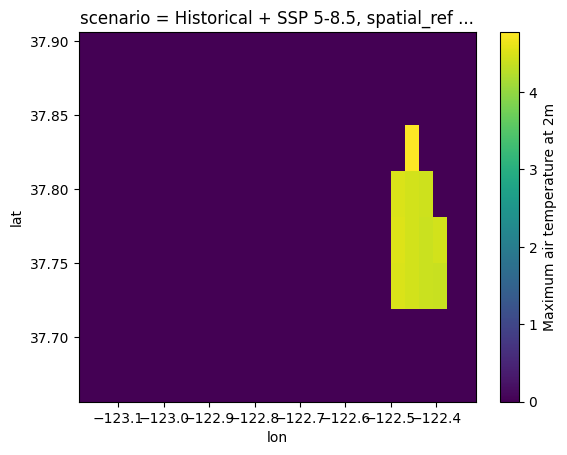

In [38]:
test.plot()

In [ ]:
percentile = 0.98
results = []

for label, time_slice in dict_slices_run.items():

    # retrieve data
    data = get_data(**max_temp_params, time_slice=time_slice)

    # for that time slice, calculate the average number of days above 98th percentile in the time slice
    result = avg_days_above_percentile(hist_data, data, percentile)

    # add time slice name as a dimension
    result = result.expand_dims({"time_slice_name": [label]})

    # now append this result to the ongoing list of results
    results.append(result)

print("iterative counts complete")

# concatenate all along the new "time_slice_name" dimension
combined_hot = xr.concat(results, dim="time_slice_name")

# add in the time ranges to the dataset coordinates
combined_hot = combined_hot.assign_coords(
    {
        "time_slice_range": (
            "time_slice_name",
            [f"{t[0]}–{t[1]}" for t in dict_slices_run.values()],
        )
    }
)

print("concatenation complete")

# rename variable
combined_hot.name = f"avg annual # extreme heat days above 98th percentile"

# export to local, as netCDF
combined_hot.to_netcdf(
    path=f"avg_extreme_heat_days_over_98th_percentile.nc", engine="netcdf4"
)

print("complete!")

/home/machuca/.local/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1634: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


### Average annual number of warm nights (based on historical 98th percentile)

In [ ]:
# retrieve historical data  to use as baseline
hist_data = get_data(**hist_min_temp_params)

In [ ]:
percentile = 0.98
results = []

for label, time_slice in dict_slices_run.items():

    # retrieve data
    data = get_data(**min_temp_params, time_slice=time_slice)

    # Apply the temperature function
    result = avg_days_above_percentile(hist_data, data, percentile)

    # Optionally attach a coordinate for the label (for clarity)
    result = result.expand_dims({"time_slice_name": [label]})

    # Collect for concatenation
    results.append(result)

# Concatenate all along the new "time_slice" dimension
combined_warm = xr.concat(results, dim="time_slice_name")

# Now add in the time ranges to the dataset coordinates
combined_warm = combined_hot.assign_coords(
    {
        "time_slice_range": (
            "time_slice_name",
            [f"{t[0]}–{t[1]}" for t in dict_slices_run.values()],
        )
    }
)

combined_warm.name = f"avg annual # warm nights above 98th percentile"

# export to local, as netCDF
combined_warm.to_netcdf(
    path=f"avg_warm_nights_over_98th_percentile.nc", engine="netcdf4"
)

In [ ]:
combined_warm.sel(time_slice_name="mid-century").squeeze().plot()

## 4. Visualize results

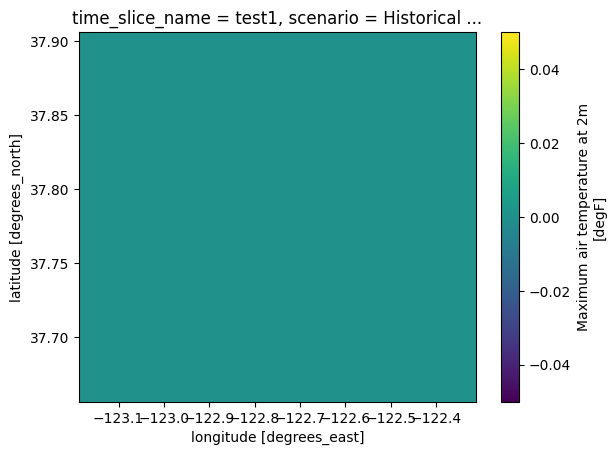

In [ ]:
combined_100.sel(time_slice_name="mid-century").squeeze().plot()

## 5. Convert to census tract level

In [39]:
def reproject_to_tracts(ds_delta, ca_boundaries):
    df = ds_delta.to_dataframe().reset_index()
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.x, df.y))
    gdf = gdf.set_crs(crs)
    gdf = gdf.to_crs(ca_boundaries.crs)

    ca_boundaries = ca_boundaries.set_index(["GEOID"])

    clipped_gdf = gpd.sjoin_nearest(ca_boundaries, gdf, how="left")
    clipped_gdf = clipped_gdf.drop(["index_right"], axis=1)
    clipped_gdf = clipped_gdf.reset_index()[["GEOID", f"{ds_delta.name}", "geometry"]]

    ### some coastal tracts do not contain any land grid cells ###
    ### due to the WRF's underlying surface type for a given grid cell. ###

    # aggregate the gridded data to the tract level
    clipped_gdf_diss = clipped_gdf.reset_index().dissolve(by="GEOID", aggfunc="mean")
    clipped_gdf_diss = clipped_gdf_diss.rename(
        columns={f"{ds_delta.name}_right": ds_delta.name}
    )

    # separate tracts with data from tracts without data
    clipped_gdf_nan = clipped_gdf_diss[np.isnan(clipped_gdf_diss[ds_delta.name])]
    clipped_gdf_nan = clipped_gdf_nan[["geometry", ds_delta.name]]
    clipped_gdf_valid = clipped_gdf_diss[~np.isnan(clipped_gdf_diss[ds_delta.name])]
    clipped_gdf_valid = clipped_gdf_valid[["geometry", ds_delta.name]]

    # compute the centroid of each tract
    clipped_gdf_nan["centroid"] = clipped_gdf_nan.centroid
    clipped_gdf_nan = clipped_gdf_nan.set_geometry("centroid")
    clipped_gdf_valid["centroid"] = clipped_gdf_valid.centroid
    clipped_gdf_valid = clipped_gdf_valid.set_geometry("centroid")

    # fill in missing tracts with values from the closest tract
    # in terms of distance between the tract centroids
    clipped_gdf_filled = clipped_gdf_nan.sjoin_nearest(clipped_gdf_valid, how="left")
    clipped_gdf_filled = clipped_gdf_filled[["geometry_left", f"{ds_delta.name}_right"]]
    clipped_gdf_filled = clipped_gdf_filled.rename(
        columns={"geometry_left": "geometry", f"{ds_delta.name}_right": ds_delta.name}
    )
    clipped_gdf_valid = clipped_gdf_valid.drop(columns="centroid")

    # concatenate filled-in tracts with the original tract which had data
    gdf_all_tracts = pd.concat([clipped_gdf_valid, clipped_gdf_filled])

    return gdf_all_tracts

In [40]:
over_90 = xr.open_dataset("avg_extreme_heat_days_over_90.nc", engine="netcdf4")

In [ ]:
reproject_test = reproject_to_tracts(over_90, ca_boundaries)

## 6. Export to NetCDF or GeoTIFF

Export the un-converted datasets to netCDF

In [ ]:
combined_90.to_netcdf(path="combined_90.nc", engine="netcdf4")

In [ ]:
combined_100.to_netcdf(path="avg_extreme_heat_days_over_100.nc", engine="netcdf4")